In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Leitura dos resultados

In [67]:
df = pd.DataFrame(columns = ['Granularity','True_Positive','True_Negative','False_Positive','False_Negative','N_Groups', 'Execution_Time'])

min_g = 1
max_g = 4

for i in range(min_g, max_g+1):
    df_aux = pd.read_csv("results/detection_info_raw_{}_0.csv".format(i))
    df_aux2 = pd.read_csv("results/performance_info_raw_{}_0.csv".format(i))
    
    df_aux["Execution_Time"] = df_aux2["Time_Elapsed"]
    
    df = pd.concat([df, df_aux])
    
df = df.reset_index()
df = df.drop('index',1)

In [68]:
df

,Granularity,True_Positive,True_Negative,False_Positive,False_Negative,N_Groups,Execution_Time
0,1.0,0.0,6000.0,0.0,60.0,3.0,0:01:00.999022
1,2.0,0.0,5998.0,2.0,60.0,29.0,0:10:33.114619
2,3.0,0.0,5984.0,16.0,60.0,97.0,1:30:47.390001
3,4.0,0.0,5963.0,37.0,60.0,220.0,6:23:17.898852


# True Positve Rate e True Negative Rate

In [37]:
tp_rate = []
fp_rate = []
    
for index, row in df.iterrows():
    accuracy_dict = row.to_dict()
    tp = accuracy_dict['True_Positive']
    tn = accuracy_dict['True_Negative']
    fp = accuracy_dict['False_Positive']
    fn = accuracy_dict['False_Negative']
        

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
        
    tp_rate.append(tpr)
    fp_rate.append(fpr)
    
tpr = np.array(tp_rate)* 100
fpr = np.array(fp_rate)* 100

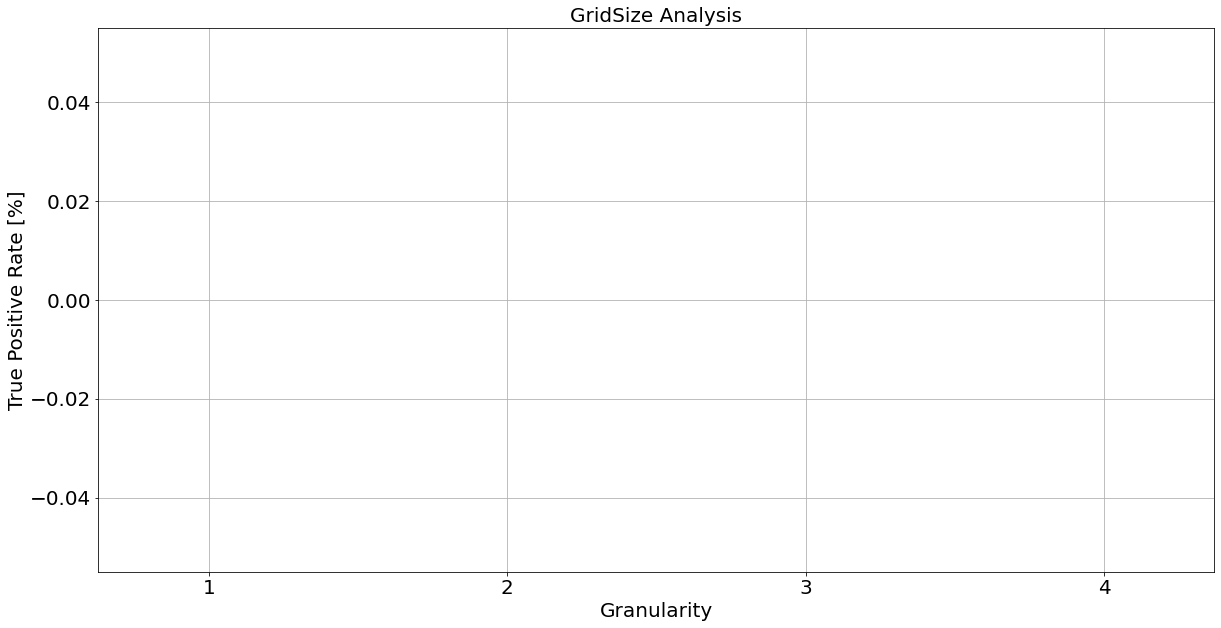

In [38]:
x = np.array(range(min_g,max_g+1))

plt.figure(figsize=(20,10))
ax = plt.subplot()

ax.bar(x, tpr, width=0.4, color='b', align='center')


ax.set_xticks(x)
ax.set_title('GridSize Analysis', fontsize=20)
ax.set_ylabel('True Positive Rate [%]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(x, df['N_Groups'], 'r.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20)
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.grid()

# plt.savefig('Detection_Rate.png', bbox_inches='tight')
plt.show()

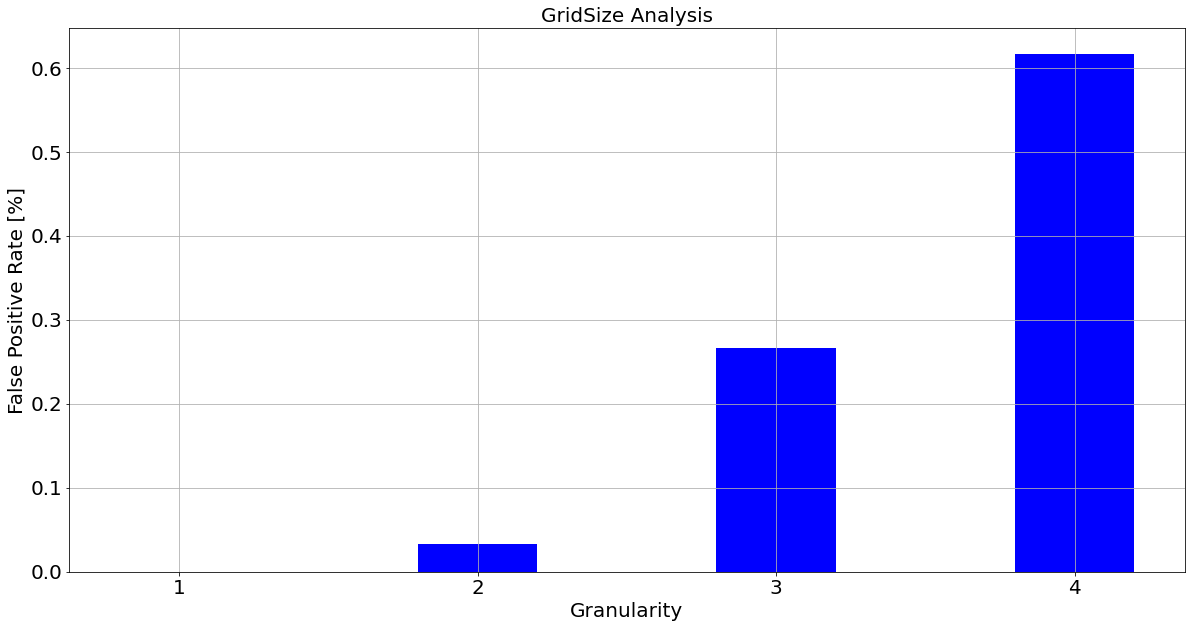

In [44]:
x = np.array(range(min_g,max_g+1))

plt.figure(figsize=(20,10))
ax = plt.subplot()

ax.bar(x, fpr, width=0.4, color='b', align='center')

ax.set_xticks(x)
ax.set_title('GridSize Analysis', fontsize=20)
ax.set_ylabel('False Positive Rate [%]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)


# plot do eixo y a direita, numero de grupos
#ax2 = ax.twinx()
#ax2.plot(x, df['N_Groups'], 'r.-', markersize=20)
#ax2.set_ylabel('N Groups', fontsize=20)
#ax2.tick_params(axis='both', which='major', labelsize=20)

plt.grid()

# plt.savefig('False_Detection_Rate.png', bbox_inches='tight')
plt.show()

# Tempo de Execução

In [40]:
df["Time_s"] = df["Execution_Time"].apply(lambda x: datetime.strptime(x,"%H:%M:%S.%f").time())

In [41]:
for i in range(df.shape[0]):
    df.loc[i,'Time_s'] = ((df.loc[i,'Time_s'].hour*60 + df.loc[i,'Time_s'].minute)*60 + df.loc[i,'Time_s'].second) + df.loc[i,'Time_s'].microsecond/1000000

In [42]:
df

,index,Granularity,True_Positive,True_Negative,False_Positive,False_Negative,N_Groups,Execution_Time,Time_s
0,0,1.0,0.0,6000.0,0.0,60.0,3.0,0:01:00.999022,60.999
1,0,2.0,0.0,5998.0,2.0,60.0,29.0,0:10:33.114619,633.115
2,0,3.0,0.0,5984.0,16.0,60.0,97.0,1:30:47.390001,5447.39
3,0,4.0,0.0,5963.0,37.0,60.0,220.0,6:23:17.898852,22997.9


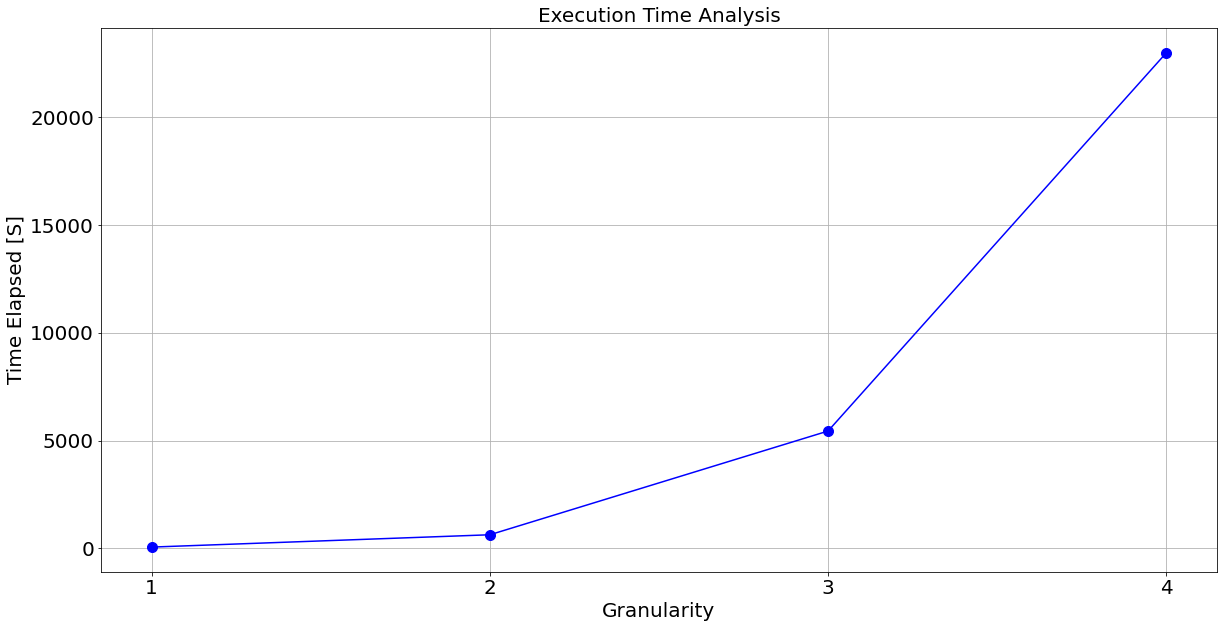

In [45]:
plt.figure(figsize=(20,10))
ax = plt.subplot()

plt.plot(df['Granularity'], df['Time_s'], 'b.-', markersize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Execution Time Analysis', fontsize=20)
ax.set_ylabel('Time Elapsed [S]', fontsize=20)
ax.set_xlabel('Granularity', fontsize=20)

ax.set_xticks(x)

plt.grid()

#plt.savefig('Execution_time.png', bbox_inches='tight')
plt.show()

# ROC

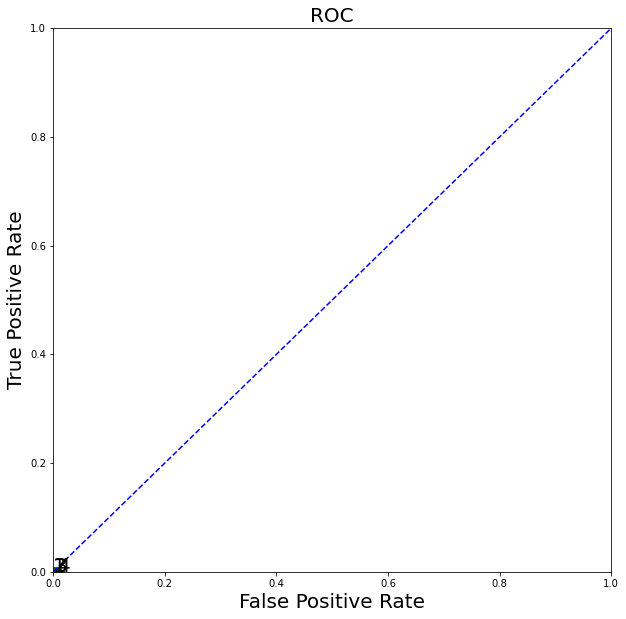

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(fp_rate, tp_rate, c='g', s=100)
for i, txt in enumerate(x):
    ax.annotate(txt, (fp_rate[i], tp_rate[i]), fontsize=20)    

ax.set_title('ROC', fontsize=20)
ax.plot([0, 1], [0, 1],'b--')    
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.show()